In [1]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


In [2]:
import pickle
import numpy as np

pncdir = '/home/anton/Documents/Tulane/Research/data-sav/anton/cohorts/PNC/'
lowrankdir = '/home/anton/Documents/Tulane/Research/Work/ContrastiveLearning/PNC/Top5/'
pncdemo = pickle.load(open(f'{pncdir}/demographics.pkl', 'rb'))

rest = []
nback = []
emoid = []
restmat = []
nbackmat = []
emoidmat = []
race = []
sex = []
age = []

a,b = np.triu_indices(264,1)

for sub in pncdemo['age_at_cnb']:
    try:
        ra = pncdemo['Race'][sub]
        ag = pncdemo['age_at_cnb'][sub]
        se = pncdemo['Sex'][sub]
        if ra not in ['AA', 'EA']:
            continue
        ra = ra == 'AA'
        se = se == 'M'
        r = np.load(f'{lowrankdir}/{sub}_task-resttop5_fc.npy')
        n = np.load(f'{lowrankdir}/{sub}_task-nbacktop5_fc.npy')
        e = np.load(f'{lowrankdir}/{sub}_task-emoidtop5_fc.npy')
        r = remap(vec2mat(r))
        n = remap(vec2mat(n))
        e = remap(vec2mat(e))
        race.append(ra)
        sex.append(se)
        age.append(ag)
        rest.append(r[a,b])
        nback.append(n[a,b])
        emoid.append(e[a,b])
        restmat.append(r)
        nbackmat.append(n)
        emoidmat.append(e)
    except:
        pass

rest = np.stack(rest)
nback = np.stack(nback)
emoid = np.stack(emoid)
restmat = np.stack(restmat)
nbackmat = np.stack(nbackmat)
emoidmat = np.stack(emoidmat)
race = np.array(race).astype('int')
sex = np.array(sex).astype('int')
age = np.array(age)

print([a.shape for a in [rest, nback, emoid, restmat, nbackmat, emoidmat, race, sex, age]])

[(1193, 34716), (1193, 34716), (1193, 34716), (1193, 264, 264), (1193, 264, 264), (1193, 264, 264), (1193,), (1193,), (1193,)]


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def rmse(a, b, mean=torch.mean):
    return mean((a-b)**2)**0.5

class AE(nn.Module):
    def __init__(self, ld, rank):
        super(AE, self).__init__()
        self.rank = rank
        self.enc1 = nn.Linear(34716, ld).float().cuda()
        self.dec1 = nn.Linear(ld, rank*264).float().cuda()

    def enc(self, x):
        return self.enc1(x)

    def dec(self, x):
        y = self.dec1(x)
        y = y.reshape(x.shape[0], 264, self.rank)
        y = torch.einsum('nab,ncb->nac', y, y)
        return y

    def decvec(self, x):
        y = self.dec(x)
        a,b = np.triu_indices(264,1)
        y = y[:,a,b]
        return y

x = np.concatenate([rest, nback, emoid])
x = torch.from_numpy(x).float().cuda()

ae = AE(1000, 5)
optim = torch.optim.Adam(ae.parameters(), lr=1e-4, weight_decay=1e-4)

nepochs = 1000
pperiod = 20
bsize = 300

for e in range(nepochs):
    for b in range(0,len(x),bsize):
        optim.zero_grad()
        bx = x[b:b+bsize]
        by = ae.enc(bx)
        by = ae.decvec(by)
        loss = rmse(bx, by)
        loss.backward()
        optim.step()
        if e % pperiod == 0 or e == nepochs-1:
            print(f'{e} {float(loss)}')

print('Done')

0 0.3819348216056824
0 1.540213704109192
0 0.4070119261741638
0 0.579119086265564
0 0.6727085709571838
0 0.5322854518890381
0 0.39372703433036804
0 0.3258865177631378
0 0.3472674787044525
0 0.3116292655467987
0 0.30654197931289673
0 0.30858945846557617
20 0.1544414460659027
20 0.15267139673233032
20 0.15371699631214142
20 0.14810214936733246
20 0.13690826296806335
20 0.13621793687343597
20 0.1320934295654297
20 0.13263875246047974
20 0.14190255105495453
20 0.14130288362503052
20 0.13759340345859528
20 0.13940292596817017
40 0.15213100612163544
40 0.14708064496517181
40 0.1475793421268463
40 0.1429605931043625
40 0.13733838498592377
40 0.13004523515701294
40 0.12898285686969757
40 0.12915362417697906
40 0.1339525580406189
40 0.13957159221172333
40 0.12973849475383759
40 0.133636474609375
60 0.1368977427482605
60 0.13592256605625153
60 0.13737568259239197
60 0.13268789649009705
60 0.12829506397247314
60 0.12602415680885315
60 0.12036165595054626
60 0.12480268627405167
60 0.12431357800960

In [125]:
# Linear regularizers

from sklearn.linear_model import Ridge, LogisticRegression

age_reg = Ridge(alpha=100).fit(np.concatenate([rest, nback, emoid], axis=0), np.concatenate([age, age, age]))
age_w = torch.from_numpy(age_reg.coef_).float().cuda()
age_i = age_reg.intercept_

sex_reg = LogisticRegression(C=100, max_iter=1000).fit(np.concatenate([rest, nback, emoid], axis=0), np.concatenate([sex, sex, sex]))
sex_w = torch.from_numpy(sex_reg.coef_[0]).float().cuda()
sex_i = sex_reg.intercept_[0]

race_reg = LogisticRegression(C=100, max_iter=1000).fit(np.concatenate([rest, nback, emoid], axis=0), np.concatenate([race, race, race]))
race_w = torch.from_numpy(race_reg.coef_[0]).float().cuda()
race_i = race_reg.intercept_[0]

rest_reg = LogisticRegression(C=100, max_iter=1000).fit(np.concatenate([rest, nback, emoid], axis=0), 
                                                        np.concatenate([np.ones(len(rest)), np.zeros(len(rest)*2)]))
rest_w = torch.from_numpy(rest_reg.coef_[0]).float().cuda()
rest_i = rest_reg.intercept_[0]

print(age_i)
print(sex_i)
print(race_i)
print(rest_i)

/usr/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


13.35469558212582
-2.2496803438137363
12.178833680422912
-6.724284941568895


In [133]:
# WGAN

import random

class Gen(nn.Module):
    def __init__(self, ld, nd):
        super(Gen, self).__init__()
        self.nd = nd
        self.enc1 = nn.Linear(6+nd, 100).float().cuda()
        self.enc2 = nn.Linear(100, ld).float().cuda()

    def forward(self, n, ag, sx, rc, rst):
        x = torch.normal(0, 1, size=(n, self.nd)).float().cuda()
        x = torch.cat([x, torch.ones(n, 1).float().cuda()*ag, 
                       torch.ones(n, 1).float().cuda()*sx, 
                       torch.ones(n, 1).float().cuda()*(1-sx),
                       torch.ones(n, 1).float().cuda()*rc, 
                       torch.ones(n, 1).float().cuda()*(1-rc),
                       torch.ones(n, 1).float().cuda()*rst], dim=1)
        x = F.relu(self.enc1(x))
        x = self.enc2(x)
        return x

ce = nn.CrossEntropyLoss()

def latToVec(ae, z):
    p = ae.decvec(z)
    return p

def clamp(disc, a):
    with torch.no_grad():
        disc.fc1.weight[disc.fc1.weight > a] = a
        disc.fc1.weight[disc.fc1.weight < -a] = -a
        disc.fc2.weight[disc.fc2.weight > a] = a
        disc.fc2.weight[disc.fc2.weight < -a] = -a

class Disc(nn.Module):
    def __init__(self):
        super(Disc, self).__init__()
        self.fc1 = nn.Linear(34716, 50).float().cuda()
        self.fc2 = nn.Linear(50, 2).float().cuda()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def rmse(a, b):
    return torch.mean((a-b)**2)**0.5

gen = Gen(1000, 10)
disc = Disc()
optimGen = torch.optim.Adam(gen.parameters(), lr=1e-4, weight_decay=1e-4)
optimDisc = torch.optim.Adam(disc.parameters(), lr=1e-4, weight_decay=1e-4)

nepochs = 30000
pperiod = 100
nb = 10

for e in range(nepochs):
    # Real samples
    # -----
    optimDisc.zero_grad()
    xb = x[np.random.permutation(len(x))[:nb]]
    fake = disc(xb)
    loss0 = ce(fake, torch.zeros(nb).long().cuda())
    loss0.backward()
    optimDisc.step()
    clamp(disc, 2e-2)
    # Fake samples for disc
    # -----
    ag = random.randint(8,20)
    sx = random.randint(0,1)
    rc = random.randint(0,1)
    rst = random.randint(0,1)
    optimDisc.zero_grad()
    with torch.no_grad():
        xb = latToVec(ae, gen(nb, ag, sx, rc, rst))
    fake = disc(xb)
    loss1 = ce(fake, torch.ones(nb).long().cuda())
    loss1.backward()
    optimDisc.step()
    clamp(disc, 2e-2)
    # Fake Samples for gen
    # -----
    optimGen.zero_grad()
    xb = latToVec(ae, gen(nb, ag, sx, rc, rst))
    fake = disc(xb)
    loss2 = 2*ce(fake, torch.zeros(nb).long().cuda())
    # Get age
    age_hat = xb@age_w+age_i
    age_loss = 0.2*rmse(age_hat, ag)
    sex_hat = xb@sex_w+sex_i
    sex_loss = 0.2*ce(torch.stack([1-sex_hat, sex_hat], dim=1), torch.ones(nb).long().cuda()*sx)
    race_hat = xb@race_w+race_i
    race_loss = 0.2*ce(torch.stack([1-race_hat, race_hat], dim=1), torch.ones(nb).long().cuda()*rc)
    rest_hat = xb@rest_w+rest_i
    rest_loss = 0.2*ce(torch.stack([1-rest_hat, rest_hat], dim=1), torch.ones(nb).long().cuda()*rst)
    (loss2+age_loss+sex_loss+race_loss+rest_loss).backward()
    optimGen.step()
    if e % pperiod == 0 or e == nepochs-1:
        print(f'{e} {float(loss0)} {float(loss1)} {float(loss2)} {sex_loss} {race_loss} {rest_loss}')
        print(ag, age_hat)

print('Done')

0 0.578568160533905 0.8017242550849915 1.211330771446228 1.785724066394323e-06 3.1035003662109375 2.160437822341919
11 tensor([13.5208, 13.4223, 13.1631, 13.8242, 12.9226, 13.1814, 13.6669, 13.4970,
        13.7431, 13.5610], device='cuda:0', grad_fn=<AddBackward0>)
100 0.0009293422917835414 0.16836482286453247 3.575251817703247 0.7018873691558838 7.152556236178498e-08 7.649363396922126e-05
10 tensor([14.2095, 14.1119, 14.4065, 14.0172, 14.2715, 14.3180, 14.1508, 14.3765,
        13.8922, 13.9773], device='cuda:0', grad_fn=<AddBackward0>)
200 0.0010951285948976874 0.20025634765625 3.5207278728485107 0.49827057123184204 2.6039674282073975 0.000205034768441692
10 tensor([13.7850, 14.1120, 13.7206, 13.7779, 13.8414, 13.4919, 13.6795, 13.9597,
        13.9741, 13.6457], device='cuda:0', grad_fn=<AddBackward0>)
300 5.607670027529821e-05 0.03759070485830307 6.104283809661865 0.009731510654091835 0.12137468159198761 0.3284018039703369
18 tensor([14.4328, 14.6619, 14.8682, 14.5387, 14.7283, 14

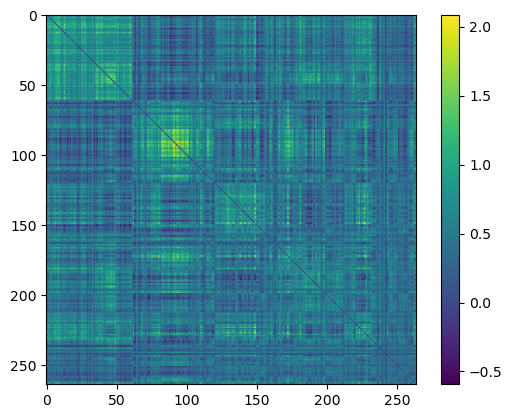

In [157]:
import matplotlib.pyplot as plt

with torch.no_grad():
    xb = latToVec(ae, gen(nb, 18, 1, 1, 1))
    
plt.imshow(vec2mat(xb[0].detach().cpu().numpy()))
plt.colorbar()
plt.show()

In [647]:
import random

class PhenoAE(nn.Module):
    def __init__(self, ld, nd):
        super(PhenoAE, self).__init__()
        self.nd = nd
        # Age, Male, Female, EA, AA
        self.enc1 = nn.Linear(5+nd, 50).float().cuda()
        self.enc2 = nn.Linear(50, ld).float().cuda()

    def forward(self, n, ag, m, f, aa, ea):
        y = torch.ones(n,1).float().cuda()
        x = torch.cat([ag*y, m*y, f*y, aa*y, ea*y], dim=1).float().cuda()
        xn = torch.normal(0, 1, size=(n, self.nd)).float().cuda()
        x = torch.cat([x, xn], dim=1)
        x = F.relu(self.enc1(x))
        x = self.enc2(x)
        return x

age_tol = 2

def get_sim(age, sex, race, ag, m, aa):
    agsel = np.abs(age-ag) < age_tol
    msel = sex == m
    rsel = race == aa
    sel = agsel * msel * rsel
    return sel

def get_diff(age, sex, race, ag, m, aa):
    agsel = np.abs(age-ag) >= age_tol
    msel = sex != m
    rsel = race != aa
    sel = agsel * msel * rsel
    return sel

cos = nn.CosineSimilarity(dim=1, eps=1e-6)

def rmse_loss(a, b):
    loss = 0
    for i in range(len(a)):
        aa = a[i:i+1].tile((len(b),1))
        err = torch.mean((aa-b)**2, dim=1)**0.5
        x = torch.exp(1/err)
        loss = loss + 1/torch.sum(x)
    return loss

def sim_loss(a):
    loss = 0
    for i in range(len(a)):
        for j in range(i+1, len(a)):
            val = rmse(a[i], a[j])
            loss += 1/val
    return loss/len(a)/(len(a)-1)*2

x = torch.from_numpy(rest).float().cuda()
with torch.no_grad():
    z = ae.enc(x)

nepochs = 2000
pperiod = 20

pae = PhenoAE(1000, 20)
optim = torch.optim.Adam(pae.parameters(), lr=1e-3, weight_decay=1e-4)

for e in range(nepochs):
    optim.zero_grad()
    ag = random.randint(8,20)
    m = random.randint(0,1)
    aa = random.randint(0,1)
    sel = np.where(get_sim(age, sex, race, ag, m, aa))[0]
    ztry = pae(5, ag, m, 1-m, aa, 1-aa)
    zztry = ae.decvec(ztry)
    with torch.no_grad():
        zsel = ae.decvec(z[sel]) 
    rloss = rmse_loss(zztry, zsel)
    sloss = 0.002*sim_loss(zztry)
    mloss = rmse(torch.mean(zztry, dim=0), torch.mean(zsel, dim=0))
    loss = rloss+sloss+mloss
    loss.backward()
    optim.step()
    with torch.no_grad():
        pae.enc1.weight[pae.enc1.weight > 0.1] = 0.1
        pae.enc1.weight[pae.enc1.weight < -0.1] = -0.1
    if e % pperiod == 0 or e == nepochs-1:
        print(f'{e} {float(loss)}')

print('Done')

0 0.32154983282089233
20 0.3178845942020416
40 0.20792415738105774
60 0.16082045435905457
80 0.17385819554328918
100 0.15311290323734283
120 0.14532123506069183
140 0.0818493589758873
160 0.15470534563064575
180 0.13275879621505737
200 0.11563972383737564
220 0.12046220153570175
240 0.08719714730978012
260 0.11373323947191238
280 0.1510390341281891
300 0.08051849901676178
320 0.17111745476722717
340 0.08532710373401642
360 0.10751862823963165
380 0.10755012184381485
400 0.06897322088479996
420 0.07131025195121765
440 0.1466817855834961
460 0.07691299915313721
480 0.09610902518033981
500 0.1672075092792511
520 0.1583492010831833
540 0.09343647956848145
560 0.09289643168449402
580 0.08104601502418518
600 0.1781553328037262
620 0.07794634252786636
640 0.08993574976921082
660 0.1293467879295349
680 0.0974108949303627
700 0.0772310271859169
720 0.07105639576911926
740 0.07774180173873901
760 0.07413624227046967
780 0.10358185321092606
800 0.07415342330932617
820 0.10419708490371704
840 0.14

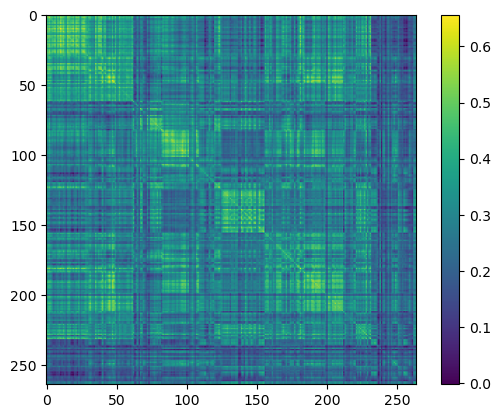

In [657]:
import matplotlib.pyplot as plt

with torch.no_grad():
    ag = random.randint(8,20)
    m = random.randint(0,1)
    aa = random.randint(0,1)
    ztry = pae(20, ag, m, 1-m, aa, 1-aa)
    res = ae.dec(ztry).detach().cpu().numpy()
    res = np.mean(res, axis=(0))
    # res[res > 1] = 1
    # res[res < -1] = -1

plt.imshow(res)
plt.colorbar()
plt.show()